In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
%matplotlib inline

In [57]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()
ttrain=train.drop('Attrition',axis=1)
all_data = pd.concat((ttrain.loc[:,'Age':],
                      test.loc[:,'Age':]))
all_data.drop('EmployeeNumber',axis=1,inplace=True)
all_data = pd.get_dummies(all_data)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.Attrition

In [58]:
all_data.head()
trial=all_data
x_train,x_test,y_train,y_test=train_test_split(all_data[:train.shape[0]],train.Attrition,train_size=0.7)


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [60]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledRandom', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.213375 (0.029355)
ScaledRandom: -0.037750 (0.017118)
ScaledKNN: -0.213313 (0.036654)
ScaledCART: -0.075501 (0.024233)
ScaledGBM: -0.102756 (0.032031)


In [61]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(x_train)
rescaledX = scaler.transform(x_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = RandomForestClassifier(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\ajayk\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


-0.040366 (0.017611) with: {'n_estimators': 50}
-0.042121 (0.017434) with: {'n_estimators': 100}
-0.039489 (0.017634) with: {'n_estimators': 200}
-0.043014 (0.017287) with: {'n_estimators': 300}
-0.042136 (0.017444) with: {'n_estimators': 400}
Best: -0.039489 using {'n_estimators': 200}


In [62]:
from sklearn.metrics import mean_squared_error

scaler = StandardScaler().fit(x_train)
rescaled_X_train = scaler.transform(x_train)
model = RandomForestClassifier(random_state=21, n_estimators=100)
model.fit(rescaled_X_train, y_train)

# transform the validation dataset
rescaled_X_test = scaler.transform(x_test)
predictions = model.predict_proba(rescaled_X_test)[:,1]

In [63]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

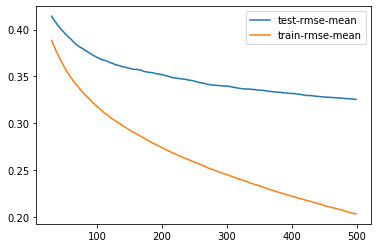

In [64]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [65]:
model_xgb = xgb.XGBClassifier(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv  n_estimators=360, max_depth=2, learning_rate=0.1
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=360, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
xgb_preds = np.expm1(model_xgb.predict_proba(x_test)[:,1])
preds = 0.7*predictions + 0.3*xgb_preds


In [67]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,preds)


0.9993752954683596

In [68]:
solution = pd.DataFrame({"id":test.Id, "Attrition":predictions})
solution.to_csv("multimodelxgb4.csv", index = False)

ValueError: array length 489 does not match index length 470